# Detección de barras en galaxias - Análisis exploratorio de datos
## Proyecto integrador MNA

### Integrantes
- Jonathan Jesús Marmolejo Hernández - A01795195
- Isaid Posadas Oropeza - A01795015
- Luis Daniel Ortega Muñoz - A01795197

### Introducción

Este notebook contiene el análisis exploratorio de datos (EDA) del proyecto "Detección de barras en galaxias". El objetivo es explorar el conjunto de datos y entender mejor las características de las galaxias, así como la distribución de la variable objetivo.

### Importar librerías y cargar datos

In [1]:
from io import BytesIO

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image

from bargal.images.client import GalaxyImageClient

In [2]:
df = pd.read_csv("../data/dataset.csv")

In [27]:
df.head()

,name,objra,objdec,Bars
0,manga-10001-12701,133.371091,57.598425,0.0
1,manga-10001-12702,133.685670,57.480250,0.5
2,manga-10001-12703,136.017160,57.092329,0.5
3,manga-10001-12704,133.989967,57.677968,0.0
4,manga-10001-12705,136.751375,57.451437,0.0


Nuestro conjunto de datos se conforma de 4 columnas:
- `name`: nombre de la galaxia
- `objra`: coordenada RA
- `objdec`: coordenada Dec
- `Bars`: etiqueta de la galaxia (si tiene barra o no, y de qué tipo)

También podemos obtener estadísticas descriptivas. Sin embargo, esto no proporciona valor, puesto que las columnas `objra` y `objdec` son coordenadas y no tienen sentido estadístico; mientras que `Bars` es una variable categórica.

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
objra,10126.0,183.138344,76.301840,0.008808,128.891916,194.107467,239.689169,359.858576
objdec,10126.0,28.624910,17.968381,-9.302426,14.652696,29.368107,43.866542,65.289735
Bars,10126.0,0.248914,0.373190,-0.500000,0.000000,0.000000,0.500000,1.000000


### Distribución de la clase objetivo

La variable objetivo es `Bars`, que representa la presencia de barras en las galaxias. Esta variable tiene 6 categorías:
- `-0.5`: Indeterminado
- `0`: Sin barra
- `0.25`: Barra débil
- `0.5`: Barra mezclada con los brazos de la galaxia
- `0.75`: Barra definida en el centro
- `1`: Barra definida y de gran tamaño relativo a la galaxia

In [4]:
df['Bars'].value_counts()

Bars
 0.00    6254
 0.50    1542
 1.00    1345
 0.75     456
 0.25     436
-0.50      93
Name: count, dtype: int64

<Axes: xlabel='Bars', ylabel='count'>

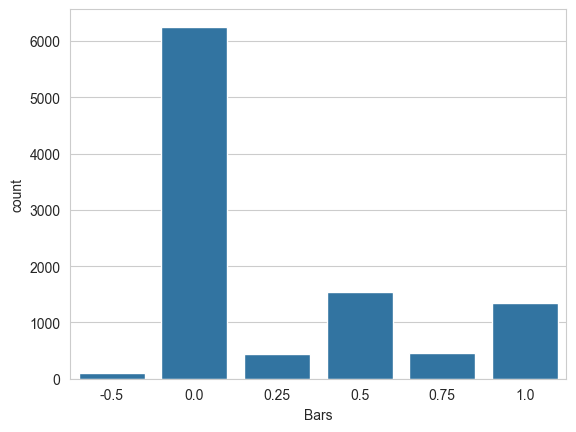

In [5]:
sns.countplot(x='Bars', data=df)

Como podemos observar, nos encontramos ante un problema de clasificación desbalanceado.

### Visualización de galaxias

La principal aplicación de este proyecto será la detección de barras en galaxias a partir de imágenes. Si bien el conjunto de datos no incluye de forma directa las imágenes, podemos obtenerlas a través de Legacy Survey, utilizando las coordenadas de la galaxia.

Como primer paso, obtenemos una muestra aleatoria de una galaxia en cada clase.

In [6]:
def get_random_galaxy(label=None):
    if label is None:
        return df.sample(1).to_dict(orient='records')[0]

    return df[df.Bars == label].sample(1).to_dict(orient='records')[0]


samples = {}

for l in df.Bars.unique():
    g = get_random_galaxy(l)
    samples[l] = g

Posteriormente, podemos utilizar la clase `GalaxyImageClient` para obtener las imágenes de las galaxias. Esta clase se encarga de descargar las imágenes y almacenarlas en un directorio local. En este caso, las imágenes se almacenarán en el directorio `../data/images`.

In [14]:
img_client = GalaxyImageClient(local_dir="../data/images")

In [23]:
imgs = {}

for g in samples.values():
    img = img_client.get_image(g)
    imgs[g['name']] = img

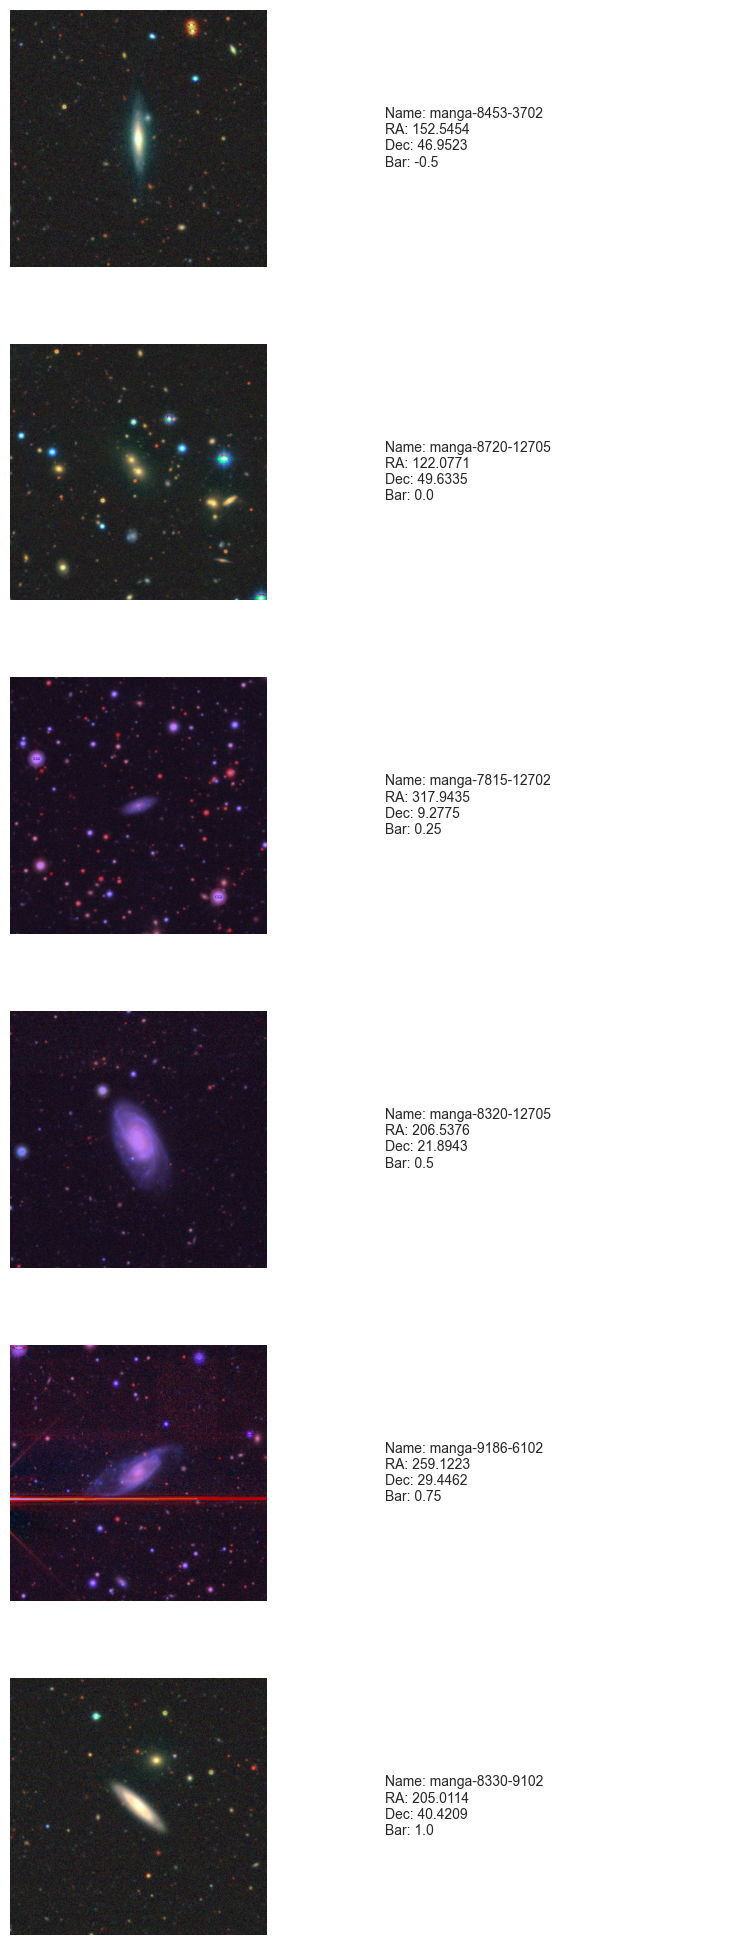

In [26]:
fig, axs = plt.subplots(6, 2, figsize=(10, 25))
plt.subplots_adjust(hspace=0.3)

for i, label in enumerate(sorted(samples.keys())):
    galaxy_data = samples[label]

    # Display image
    img_bytes = imgs[galaxy_data['name']]
    img = Image.open(BytesIO(img_bytes))
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')

    # Display properties
    props = f"Name: {galaxy_data['name']}\nRA: {galaxy_data['objra']:.4f}\nDec: {galaxy_data['objdec']:.4f}\nBar: {galaxy_data['Bars']}"
    axs[i, 1].text(0, 0.5, props, fontsize=10, va='center')
    axs[i, 1].axis('off')

plt.show()